# Import

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from collections import  defaultdict
from torch.utils.data import Dataset, DataLoader

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("DEVICE = ", DEVICE)


DEVICE =  cuda


# Dataset 

In [17]:
root = os.getcwd()
train_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialNoAnomaly', 'artificialNoAnomaly', 'art_daily_small_noise.csv')
valid_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialWithAnomaly', 'artificialWithAnomaly', 'art_daily_jumpsdown.csv')
test_dataset_path = os.path.join(root, 'dataset', 'NAB', 'artificialWithAnomaly', 'artificialWithAnomaly', 'art_daily_jumpsup.csv')

assert os.path.exists(train_dataset_path), f"Path to train dataset {train_dataset_path} not found"
assert os.path.exists(valid_dataset_path), f"Path to valid dataset {valid_dataset_path} not found"
assert os.path.exists(test_dataset_path), f"Path to test dataset {test_dataset_path} not found"

# Prepare train, valid, and test datasets

In [18]:
train_df = pd.read_csv(train_dataset_path)
valid_df = pd.read_csv(valid_dataset_path)
test_df = pd.read_csv(test_dataset_path)

print('train df = ', train_df.shape)
print('valid df = ', valid_df.shape)
print('test df = ', test_df.shape)
train_df['timestamp'] = train_df.timestamp.astype("datetime64[ns]")
valid_df['timestamp'] = valid_df.timestamp.astype("datetime64[ns]")
test_df['timestamp'] = test_df.timestamp.astype("datetime64[ns]")
train_df.head()

train df =  (4032, 2)
valid df =  (4032, 2)
test df =  (4032, 2)


,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120


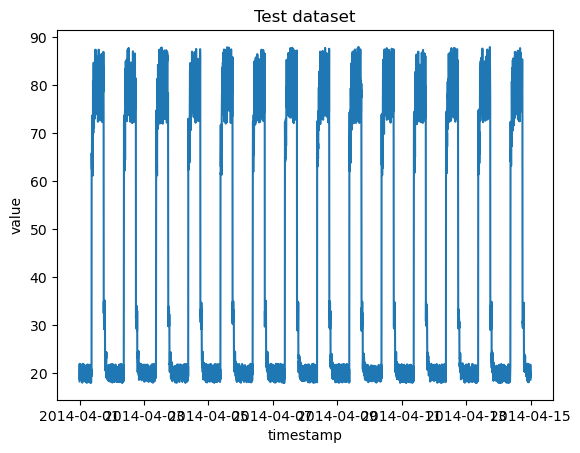

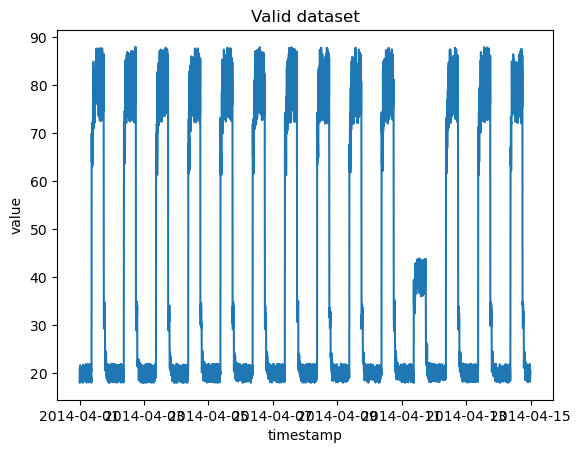

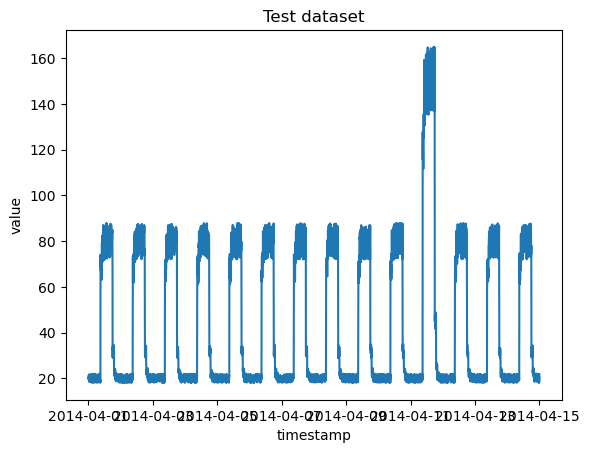

In [19]:
sns.lineplot(y = train_df['value'], x = train_df['timestamp'])
plt.title("Test dataset")
plt.show()
sns.lineplot(y = valid_df['value'], x = valid_df['timestamp'])
plt.title("Valid dataset")
plt.show()
sns.lineplot(y = test_df['value'], x = test_df['timestamp'])
plt.title("Test dataset")
plt.show()

# Make Sequence

In [20]:
def normalize(df):
    df = (df - df.min())/(df.std())
    return df

def normalize_std(df):
    df = (df - df.mean())/(df.std())
    return df

def make_sequence(df, col, scaler,  time_step = 200, debug = False):
    #make sure to normalize columns

    array = []
    values = scaler.transform(df[col].values.reshape(-1,1))
    values = values.reshape(-1)

    for i in range(len(values) - time_step + 1):
        array.append(values[i: i + time_step])

    array = np.stack(array)
    if debug:
        print(f'array mean = {np.mean(array)}, max = {np.max(array)}, min = {np.min(array)}, std = {np.std(array)}')
    
    return torch.tensor(array)


# scaler = MinMaxScaler()
# test = scaler.fit_transform(train_df['value'].values.reshape(-1,1))

# X_train = make_sequence(train_df, 'value', scaler = scaler, debug = True)
# X_valid = make_sequence(valid_df, 'value', scaler = scaler, debug = True)
# X_test = make_sequence(test_df, 'value',   scaler = scaler, debug = True)
# print('X train = ', X_train.shape)
# print('X valid = ', X_valid.shape)
# print('X test = ', X_test.shape)


# CONV1D model

In [36]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size = 16, dropout = 0.2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=hidden_size, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=hidden_size, out_channels=1, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LazyLinear(100),
            nn.ReLU()
        )

        self(torch.zeros(1, input_size))

        
    
    def forward(self, X):

        X = X.unsqueeze(1)
        X = self.encoder(X)
        return self.decoder(X)


In [22]:
# ae = Autoencoder(input_size=100)
# x = torch.rand(10,100)

# output = ae(x)
# print(output.shape)
    

In [23]:
def tune(model, X_train, optimizer, criterion, epochs = 1000):

    loop = tqdm(range(epochs))
    history = defaultdict(list)
    for e in loop:
        model.train()

        X_pred = model(X_train)

        loss = criterion(X_pred, X_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history['train loss'].append(loss.item())

        loop.set_description(f'e = {e}, train loss = {loss.item():.3f}')

    return model, history

In [ ]:
def run_model()

In [24]:
# encoder = nn.Sequential(
#     nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Conv1d(in_channels=32, out_channels=16, kernel_size=7, stride=1),
#     nn.ReLU(),
#     nn.Dropout(0.5),
# )


# # decoder = nn.Sequential(
# #     nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=7, stride=2),
# #     nn.ReLU(),
# #     nn.Dropout(0.5),
# #     nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=7, stride=2),
# #     nn.ReLU(),
# #     nn.Dropout(0.5),
# # )
# x = torch.rand(10,1,100)

# output = encoder(x)
# print(output.shape)
#     decoder = nn.Sequential(
#     nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=7, stride=2),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=7, stride=2),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.LazyLinear(100),
#     nn.ReLU()
# )

# x = torch.rand(10,16,88)

# y = decoder(x)
# print(y.shape)


In [25]:
def tunev2(model, dataloader, optimizer, criterion, epochs = 1000, device = DEVICE):
    print('device = ', device)
    model.to(device)

    history = defaultdict(list)
    loop = tqdm((range(epochs)))
    for e in loop:
        model.train()
        running_loss = 0.0

        for X in dataloader:
            X = X.to(device)

            X_pred = model(X)

            loss = criterion(X_pred, X)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss /= len(dataloader)
        loop.set_description(f'e = {e}, train loss = {running_loss:.3f}')
        history['train loss'].append(loss.item())

    return model, history

def plot(history):
    indices = list(range(len(history['train loss'])))
    sns.lineplot(y = history['train loss'], x =indices, label = 'train')
    plt.title("Train Loss")
    plt.show()

# Set Threshold
### Question
- why do we use MAE over MSE while choosing threshold? 

In [26]:
def get_threshold(autoencoder, X, plot = False, percentile = 100):
    # Use maximum reconstruction error of train data as threshold 
    # X_train = make_sequence(df, 'value', time_step=timestep)
    train_reconstruction = autoencoder(X.float())

    mae_loss = get_mae(X, train_reconstruction)
    mae_loss = mae_loss.squeeze(0).detach().cpu().numpy()

    if plot:
        plot_reconstruction_error_dist(mae_loss)

    threshold = np.percentile(mae_loss, percentile)
    return threshold

def plot_reconstruction_error_dist(mae_loss_array):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.hist(mae_loss_array, bins=50, density=True, label="clean", alpha=.6, color="green")
    plt.title('reconstruction  loss histogram')
    plt.show()

def plot_reconstruction(autoencoder, df, timestep, scaler, device = DEVICE):
    real_values = scaler.transform(df['value'].values.reshape(-1,1)).reshape(-1)
    X = make_sequence(df, 'value', time_step=timestep, scaler = scaler ).to(device)
    reconstruction = autoencoder(X.float())

    reconstruction = reconstruction[:,1].detach().cpu().numpy()
    indices = list(range(len(reconstruction)))
    sns.lineplot(y = real_values, x = df['value'].index)
    plt.title("Test dataset")
    sns.lineplot(y = reconstruction, x = indices, label = 'reconstruction', color = 'red')
    plt.title('reconstruction')
    plt.show()

def get_mae(input, target):
    return torch.mean(torch.abs(target - input), dim = 1)



# Detect anomaly

In [27]:
def detect_anomaly(autoencoder, df, timestep, scaler, threshold, device= DEVICE):
    # timestep = 300
    X_valid = make_sequence(df, 'value', time_step= timestep, scaler = scaler).to(device)

    valid_reconstruction = autoencoder(X_valid.float())

    mae_loss = get_mae(X_valid, valid_reconstruction)
    print('mae loss = ', mae_loss)

    anomaly_indices = (mae_loss > threshold).detach().cpu().numpy()
    valid_reconstruction = valid_reconstruction.detach().cpu().numpy()
    X_valid = X_valid.detach().cpu().numpy()

    anomaly_df = df[:df.shape[0] - timestep + 1].iloc[anomaly_indices]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
    sns.lineplot(y = valid_reconstruction[100], x = list(range(timestep)), label = 'reconstruction', color = 'red', ax = ax1)
    sns.lineplot(y = X_valid[100], x = list(range(timestep)), label = 'target', ax = ax1)
    ax1.set_title('Reconstruction per instance')
    sns.lineplot(y = df['value'], x = df.index, label = 'target', ax = ax2)
    sns.lineplot(y = anomaly_df['value'], x = anomaly_df.index, label = 'anomaly', color = 'red', ax = ax2)
    ax2.set_title(f'Abnormal with threshold={threshold}')
    plt.show()





# Dataset

In [28]:
class UnsupervisedDatset(Dataset):

    def __init__(self, X):
        self.X =X
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, **kwargs):
        return DataLoader(self, **kwargs)

    def __str__(self):
        print(f'len = {len(self.X)}')
        return ''



In [29]:
train_dataset = UnsupervisedDatset(X_train)
train_dataloader = train_dataset.get_dataloader(batch_size = 32)

print(train_dataset)
print('len train dataloader = ', len(train_dataloader))


len = 3933

len train dataloader =  123


In [30]:
def create_dataset(li,**dataloader_kwargs):
    result = []
    for item in li:
        ds = UnsupervisedDatset(item)
        result.append((ds, ds.get_dataloader(**dataloader_kwargs)))
    
    return result

result = create_dataset([X_train, X_valid, X_test], batch_size = 32)
(train_dataset, train_dataloader),(valid_dataset, valid_dataloader),(test_dataset, test_dataloader) = result
print(f"train_dataloader len = {len(train_dataloader)}")

train_dataloader len = 123


# Exp 1

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


array mean = 0.3562075109117898, max = 1.0, min = 0.0, std = 0.40286404712158896
array mean = 0.34261043131527047, max = 1.0003180201807336, min = 1.5375989619259567e-05, std = 0.3948631873593341
array mean = 0.38633823340171736, max = 2.099981013951405, min = 6.545079308528656e-07, std = 0.4658941200633877
train_dataloader len = 123
X_Train shape =  torch.Size([3933, 100])
device =  cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 100])) that is different to the input size (torch.Size([32, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([29, 100])) that is different to the input size (torch.Size([29, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
e = 999, train loss = 0.053: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]


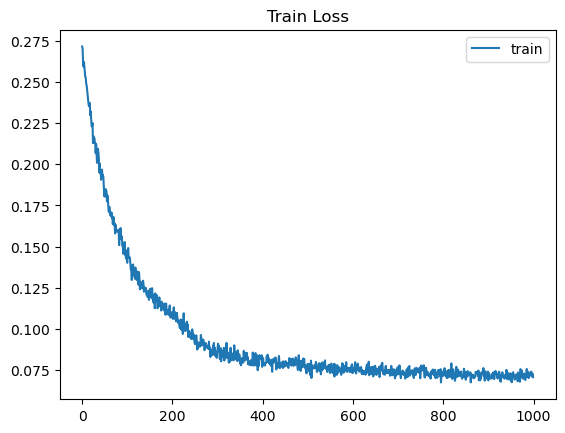

In [37]:
EMBEDDING_SIZE = 16
LR = 1e-3
TIME_STEP = 100
EXPERIMENT_NAME = 'v1'

tmp_df = train_df.copy() 
scaler = MinMaxScaler()
test = scaler.fit_transform(train_df['value'].values.reshape(-1,1))

X_train = make_sequence(train_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_valid = make_sequence(valid_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_test = make_sequence(test_df, 'value',   time_step= TIME_STEP, scaler = scaler, debug = True)

X_train = X_train.float()
X_valid = X_valid.float()
X_test = X_test.float()

result = create_dataset([X_train, X_valid, X_test], batch_size = 32)
(train_dataset, train_dataloader),(valid_dataset, valid_dataloader),(test_dataset, test_dataloader) = result
print(f"train_dataloader len = {len(train_dataloader)}")

print("X_Train shape = ", X_train.shape)

autoencoder = Autoencoder(input_size = TIME_STEP, hidden_size= EMBEDDING_SIZE, dropout = 0.2)
# autoencoder.to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(autoencoder.parameters(), lr = LR)
autoencoder, history = tunev2(autoencoder, train_dataloader, optimizer, criterion, epochs = 1000)

plot(history)

torch.save(autoencoder, f'autoencoder_{TIME_STEP}d.conv.{EXPERIMENT_NAME}.torch')


ValueError: The 'color' keyword argument must have one color per dataset, but 100 datasets and 1 colors were provided

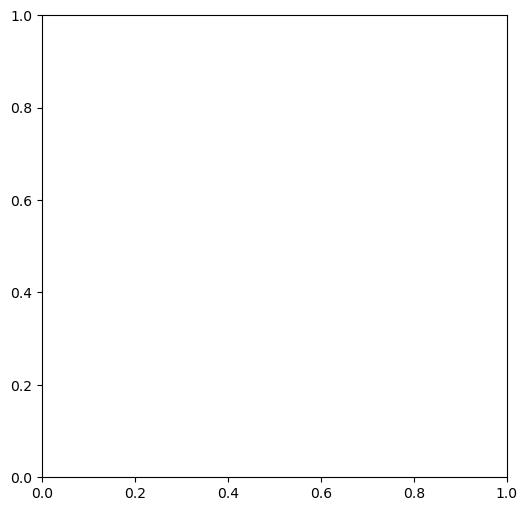

In [34]:
threshold = get_threshold(autoencoder, X_train, plot = True)
print('reconstruction threshold = ', threshold)
plot_reconstruction(autoencoder, train_df, TIME_STEP, scaler)

#evaluate
detect_anomaly(autoencoder, valid_df, TIME_STEP, scaler = scaler, threshold=threshold)
detect_anomaly(autoencoder, test_df, TIME_STEP,  scaler = scaler, threshold = threshold)

# Exp 2

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


array mean = 0.34930453425857083, max = 1.0, min = 0.0, std = 0.4012603985597367
array mean = 0.334757765626866, max = 1.0003180201807336, min = 1.5375989619259567e-05, std = 0.39239363825898665
array mean = 0.3808688941541068, max = 2.099981013951405, min = 6.545079308528656e-07, std = 0.4679912432337424


e = 4999, train loss = 0.012: 100%|██████████| 5000/5000 [04:29<00:00, 18.52it/s]


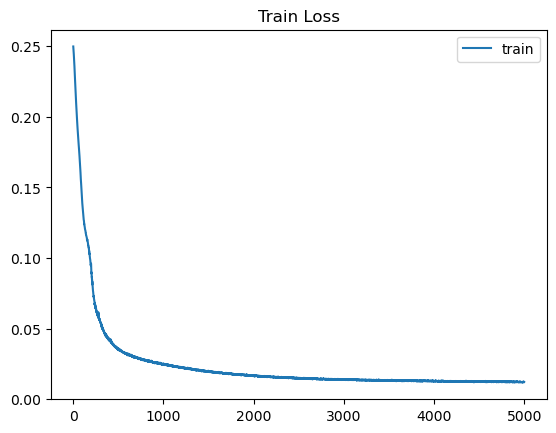

In [ ]:
EMBEDDING_SIZE = 10
LR = 1e-3
TIME_STEP = 300
EXPERIMENT_NAME = 'v2'

scaler = MinMaxScaler()
test = scaler.fit_transform(train_df['value'].values.reshape(-1,1))

X_train = make_sequence(train_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_valid = make_sequence(valid_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_test = make_sequence(test_df, 'value',   time_step= TIME_STEP, scaler = scaler, debug = True)

X_train = X_train.float().to(DEVICE)
X_valid = X_valid.float().to(DEVICE)
X_test = X_test.float().to(DEVICE)

autoencoder = AutoencoderV2(input_size = TIME_STEP, hidden_size= EMBEDDING_SIZE, dropout = 0.2)

autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = LR)
autoencoder, history = tune(autoencoder, X_train, optimizer, criterion, epochs = 5000)

plot(history)

torch.save(autoencoder, f'autoencoder_{TIME_STEP}d.lstm.{EXPERIMENT_NAME}.torch')


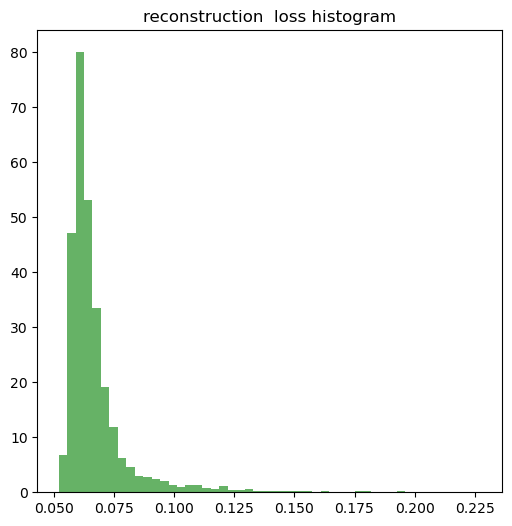

reconstruction threshold =  0.22768886387348175


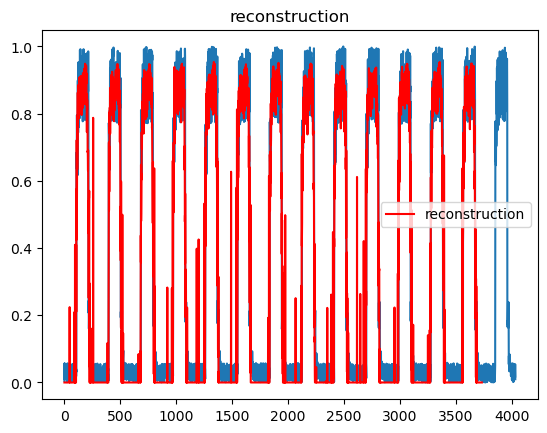

mae loss =  tensor([0.0696, 0.0815, 0.0670,  ..., 0.0616, 0.0668, 0.0629], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


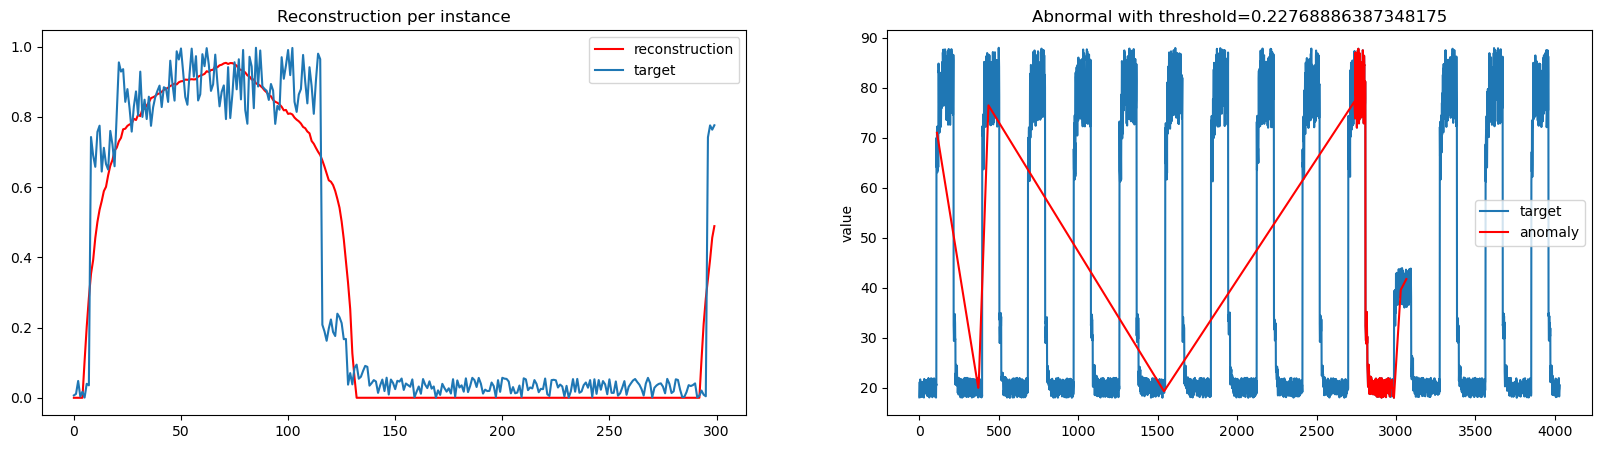

mae loss =  tensor([0.0712, 0.0813, 0.0656,  ..., 0.0693, 0.0601, 0.0616], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


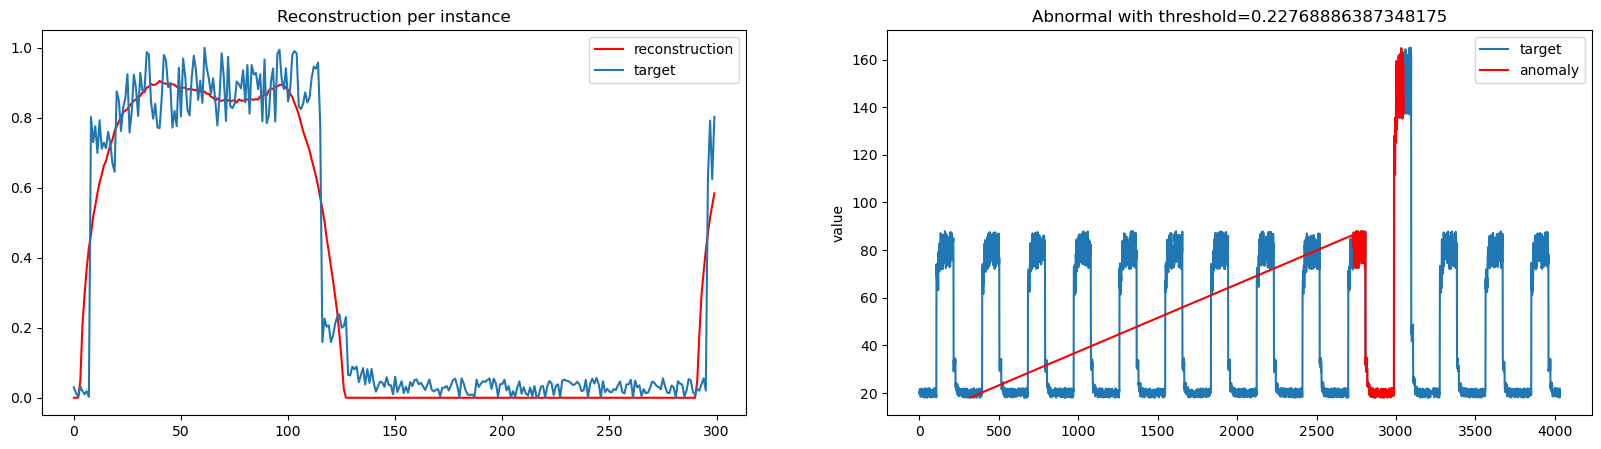

In [ ]:
threshold = get_threshold(autoencoder, X_train, plot = True)
print('reconstruction threshold = ', threshold)
plot_reconstruction(autoencoder, train_df, TIME_STEP, scaler)

#evaluate
detect_anomaly(autoencoder, valid_df, TIME_STEP, scaler = scaler, threshold=threshold)
detect_anomaly(autoencoder, test_df, TIME_STEP,  scaler = scaler, threshold = threshold)


# Exp 3

array mean = 0.3562075109117898, max = 1.0, min = 0.0, std = 0.40286404712158896
array mean = 0.34261043131527047, max = 1.0003180201807336, min = 1.5375989619259567e-05, std = 0.3948631873593341
array mean = 0.38633823340171736, max = 2.099981013951405, min = 6.545079308528656e-07, std = 0.4658941200633877
X train =  torch.Size([3933, 100])
X valid =  torch.Size([3933, 100])
X test =  torch.Size([3933, 100])


  0%|          | 0/2000 [00:00<?, ?it/s]

e = 1999, train loss = 0.005: 100%|██████████| 2000/2000 [01:27<00:00, 22.81it/s]


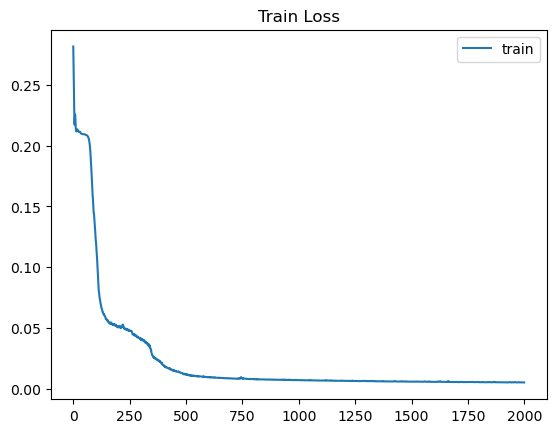

In [ ]:
EMBEDDING_SIZE = 10
LR = 1e-3
TIME_STEP = 100
EXPERIMENT_NAME = 'v3'

# X_train = make_sequence(train_df, 'value', time_step=TIME_STEP)
# X_valid = make_sequence(valid_df, 'value', time_step=TIME_STEP)
# X_test = make_sequence(test_df, 'value', time_step=TIME_STEP)


scaler = MinMaxScaler()
test = scaler.fit_transform(train_df['value'].values.reshape(-1,1))

X_train = make_sequence(train_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_valid = make_sequence(valid_df, 'value', time_step= TIME_STEP, scaler = scaler, debug = True)
X_test = make_sequence(test_df, 'value',   time_step= TIME_STEP, scaler = scaler, debug = True)
print('X train = ', X_train.shape)
print('X valid = ', X_valid.shape)
print('X test = ', X_test.shape)

X_train = X_train.float().to(DEVICE)
X_valid = X_valid.float().to(DEVICE)
X_test = X_test.float().to(DEVICE)

autoencoder = Autoencoder(input_size = TIME_STEP, hidden_size= EMBEDDING_SIZE, dropout = 0.2)

autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = LR)
autoencoder, history = tune(autoencoder, X_train, optimizer, criterion, epochs = 2000)

plot(history)

torch.save(autoencoder, f'autoencoder_{TIME_STEP}d.lstm.{EXPERIMENT_NAME}.torch')


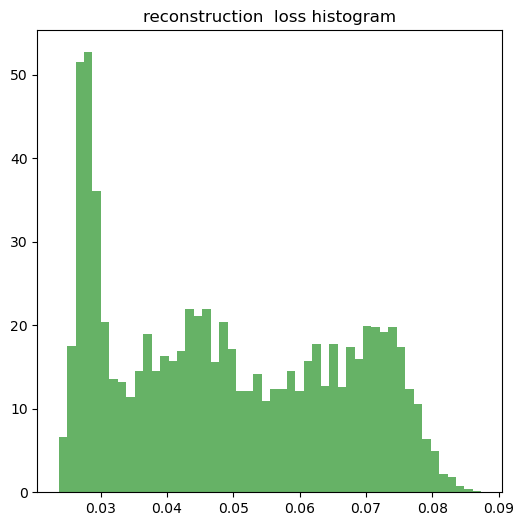

reconstruction threshold =  0.08738500624895096


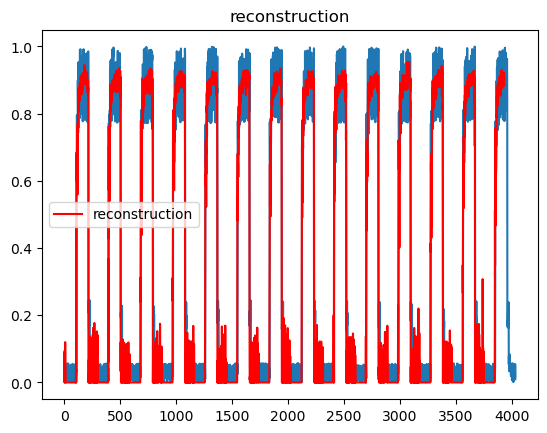

mae loss =  tensor([0.0294, 0.0294, 0.0300,  ..., 0.0553, 0.0541, 0.0545], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


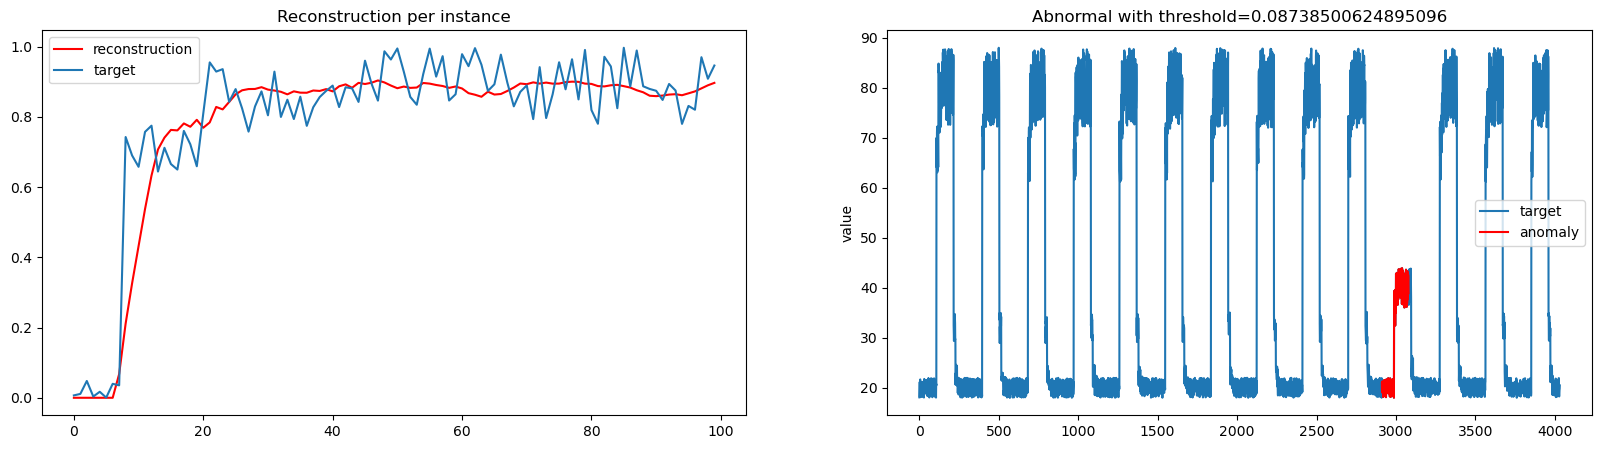

mae loss =  tensor([0.0292, 0.0296, 0.0304,  ..., 0.0541, 0.0541, 0.0532], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


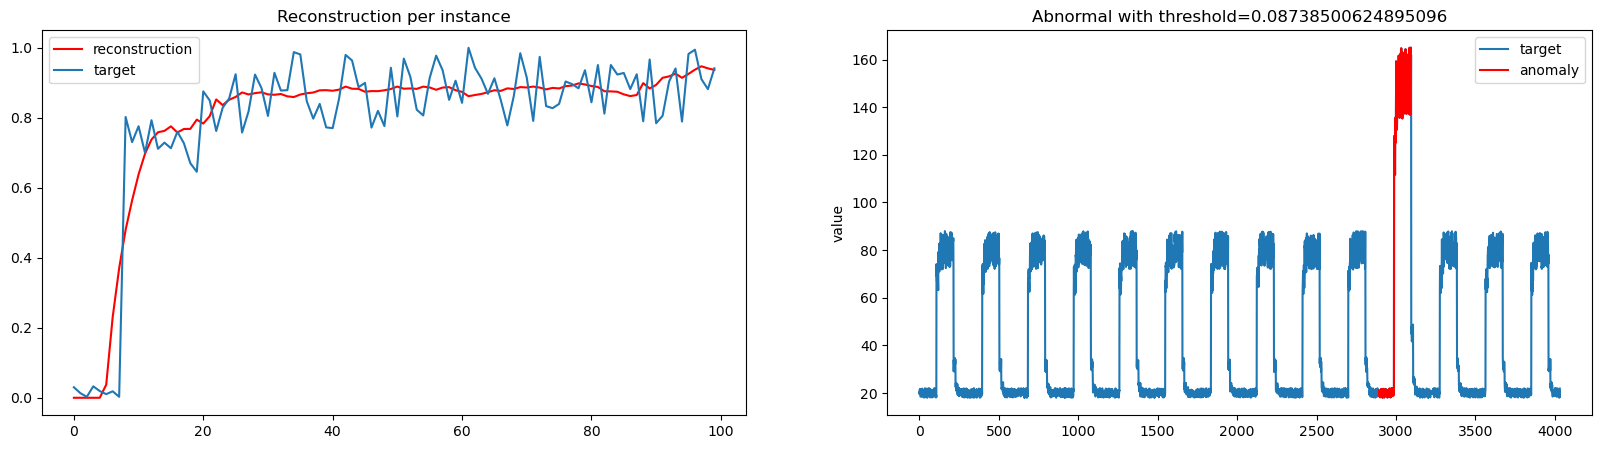

In [ ]:
threshold = get_threshold(autoencoder, X_train, plot = True)
print('reconstruction threshold = ', threshold)
plot_reconstruction(autoencoder, train_df, TIME_STEP, scaler)

#evaluate
detect_anomaly(autoencoder, valid_df, TIME_STEP, scaler = scaler, threshold=threshold)
detect_anomaly(autoencoder, test_df, TIME_STEP,  scaler = scaler, threshold = threshold)

# Observation

After many trials, we conclude that linear layer can somewhat resemble the original data, but not very accurate. It can tell the location of anomaly like in previous valid and test plot reconstruction. But it's a little a ahead of the actual anomaly. 